# Salary Predictions Based on Job Descriptions

### Define the problem 

<div class="alert alert-block alert-info"> <p><b>The objective of this project is build a model that will be able to reliably predict a salary when given a set of inputs.</b></p>

<p>The training data is contained in two comma spearated file.</p>
<p>1. train_features.csv &mdash; this file contains all the necessary fileds to create the features</p>
<p>2. train_salaries.csv &mdash; this file contain the actual salaries that we can use to score the accuracy our model</p> 
<p>3. test_features.csv &mdash; this file will be used to test our best performing model.</p>

<p>Once the data is loaded, we will look at it in a variety of different ways to ensure the validity and integrity of the data.  Should any missing data, outliers or nonsensical data be encountered, it will be dealt with programmatically and fully documented with the approval of the projects sponsors.  Understanding that this could be a very time consuming step depending on the cleanliness of our original data.</p>

<p>The success of the model will be measure by the mean squared error that it returns.  For the model to be deemed acceptable, the mean squared error should be in the range from 320 to 360.</p>

<p>Initally we will construct a very rudimentary model just to get a baseline number for mean squared error.
From there we will decide on three models (estimators) that we feel are particularly well suited to solve this kind of problem.  To achieve our target range of 320 to 360, we will follow an iterative process on all three models.  That being:</p>
<p>1. Create the features</p>
<p>2. Tune the hyper&ndash;parameters of the model</p>
<p>3. Run the model</p>
<p>4. Evaluate the results</p>
<p>5. Repeat as necessary</p>

<p>Once we have achieved the target accuracy we will save the estimator that produced the results.</p>
<p>We will then do some very minimal data transformation of the test_fetures.csv file to get it into the proper format to be accepted by our model.</p>
<p>We will reload the model, run our test file through it and check the first 10 results of the salary predictions that it produced.</p>

<p>At this point we have completed all the requirements for this project!</p>


</div>

### Initial Imports 

In [1]:
__author__ = "Jim Woodward"
__email__ = "jimwoodward81@gmail.com"

import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import pickle

## used to format and color print output
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

### Load Data Class 

In [2]:
class LoadData:
    ''' This class will load the csv files dynamically. 
        It accepts a variable number of arguments.'''
    
    def __init__(self, *args):
        self.args = args
                
    def load(self):
        list_of_df=[]
        for x in self.args:
            fname = pd.read_csv(x)
            list_of_df.append(fname)
            
        return list_of_df[0], list_of_df[1], list_of_df[2]
            

### Data Investigation Class

In [3]:
class InvestigateData:
    """Gets and prints the spreadsheet's header columns

    Parameters
    ----------
    train_feat : DataFrame
        Training dataframe containing all the fields to build our features with
    test_feat : DataFrame
        Testing dataframe to be used when we have a finished model
    train_sal : DataFrame
        Training dataframe containing the salaries, to be used as targets
    

    Returns
    -------
    DataFrames -- self.feat_sal_return, self.basecase_merge
        
    """    
        
    def __init__(self, train_feat, test_feat, train_sal):
        self.train_feat = train_feat
        self.test_feat  = test_feat
        self.train_sal  = train_sal
        self.feat_sal_return = pd.DataFrame()
                
    @staticmethod   
    def get_data_info(**kwargs):
        for i, j in kwargs.items():
            print(10*'=' + ' ' + color.RED + i + color.END + color.BOLD + 
                  ' first 5 rows ' + color.END + 10*'=' + '\n')
            display(print(j.head()))
            print(10*'=' + ' ' + color.RED + i + color.END + color.BOLD + 
                  ' Information ' + color.END + 10*'=' + '\n')
            print(j.info())
            print(10*'=' + ' ' + color.RED + i + color.END + color.BOLD + 
                  ' Description ' + color.END  + 10*'=' + '\n')
            print(j.describe())
            print()
            
    def data_investigate(self):
        ## merge salary in with the training data
        self.basecase_merge = self.train_feat.merge(self.train_sal, how='left', on='jobId')
        self.feat_sal_merge = self.train_feat.merge(self.train_sal, how='left', on='jobId')
        self.out_feat_sal_merge = self.test_feat.merge(self.train_sal, how='left', on='jobId')
        
        self.working_df = self.feat_sal_merge
                    
        #look for missing data or not a number
        if self.working_df.isna().sum()[0] == 0:
            print(color.BOLD + 'No records with NaN found.' + color.END)
            print('\n')
        else:
            print(color.RED + 'Attention: Need to deal with NaN values.' + color.END)
            print('\n')
        #look for duplicate data
        if self.working_df.duplicated().sum() == 0:
            print(color.BOLD + 'No duplicate records found.' + color.END)
            print('\n')
        else:
            print(color.RED + 'Attention: Need to deal with duplicates.' + color.END)
            print('\n')
            
        ## check value counts
        print(color.BOLD + 'Value Counts by Degree' + color.END)
        print(self.working_df['degree'].value_counts())
        print('\n')
        print(color.BOLD + 'Value Counts by Major' + color.END)
        print(self.working_df['major'].value_counts())
        print('\n')
        print(color.BOLD + 'Value Counts by Industry' + color.END)
        print(self.working_df['industry'].value_counts())
            
        if len(self.working_df[self.working_df['salary'] == 0]) > 0:
            ## calculate the lower fence of a box plot, 
            ## we'll use this a the lower threshod for salary
            self.lower_fence = (self.working_df.describe()['salary'][4] - 
               (1.5 * (self.working_df.describe()['salary'][6] - 
                       self.working_df.describe()['salary'][4])))
            ## remove any entry where the salary is not greater than the lower fence
            self.mask_sal = self.working_df['salary'] > self.lower_fence
            self.working_df = self.working_df[self.mask_sal]
            ##print(self.feat_sal_merge[self.mask1])
            print('\n')
            print(color.BOLD + 'Salaries of 0 dollars are suspicious '  
                             + 'and we will drop all salaries that are ' 
                             + 'below the lower fence of the IQR.' + color.END)
            print('\n')
            
        self.feat_sal_return = self.working_df
            
        return (self.feat_sal_return, self.basecase_merge)
            
    def save_clean_file(self):
        self.feat_sal_merge.to_csv('Feat_Sal_Merge_Clean.csv')
                    

###  EDA Class &mdash;  Explore the data  

In [4]:
class EDA:
    """ Does the exploratory data analysis

    Parameters
    ----------
    df: DataFrame to analyze
    jobT: column to use in analysis
    sal: column to use in analysis
    deg: column to use in analysis
    ind: column to use in analysis
    maj: column to use in analysis
    job_type: list of all the available job types
       
    Returns
    -------
    Nothing
        
    """
    def __init__(self, df, jobT, sal, deg, ind,  maj, job_type):
        self.df         = df
        self.sal        = sal
        self.jobT       = jobT
        self.ind        = ind
        self.deg        = deg
        self.maj        = maj
        self.job_type   = job_type
                
    def plot_sal(self):
        plt.figure(figsize=(15,8))
        sns.distplot(self.df[self.sal])
        plt.axvline(x=self.df[self.sal].mean(), linewidth=4, color='r')
        plt.text(self.df[self.sal].mean()+.1,0,'Mean')                 
        plt.xlabel('Salary', fontsize=16)
        plt.savefig('{}/{}'.format('images', 'salary_dist.png'), bbox_inches='tight')
        plt.show();
        print('The average overall salary is {}'.format(np.round(self.df[self.sal].mean()),
                                                        decimals = 0))
        print('The salary standard deviation is {}'.format(np.round(self.df[self.sal].std()),
                                                           decimals = 0))
        
    def plot_violin(self):
        violin_type = [self.deg, self.ind, self.maj]
            
        for i in violin_type:
            plt.figure(figsize=(15,8))
            sns.set(font_scale=1.5, palette='coolwarm')
            sns.violinplot(data=self.df, x=i, y=self.sal, hue=self.jobT, 
                           dodge=True, hue_order=self.job_type)
            plt.title('Salary Distribution By ' + str(i).title())
            plt.ylabel('Salary', fontsize=16)
            if i == 'industry':
                plt.xlabel('Industry', fontsize=16)
                fname = 'Industry_violin.png'
            elif i == 'degree':
                plt.xlabel('Level of Education', fontsize=16)
                fname = 'Degree_violin.png'
            elif i == 'major':
                plt.xlabel('Field of Study', fontsize=16)
                fname = 'Major_violin.png'
            plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), 
                       ncol=4, fancybox=True, shadow=True)
            plt.savefig('{}/{}'.format('images', fname), bbox_inches='tight')
            plt.show();
            

### Baseline Model Class &mdash; using linear regression

In [5]:
class Baseline:
    """ Runs a basline linear regression model with limited features 
        just to get a basline measure of the mean squared errorr.
        Future models will be compared to this one for validity.

    Parameters
    ----------
    df: feature DataFrame 
    est: estimator to use for baseline measure
    yrsExp:  feature to use
    mileMetro:  feature to use
    sal: target
           
    Returns
    -------
    Nothing
        
    """
    def __init__(self, df, est, yrsExp, milesMetro, sal):
        self.df         = df
        self.sal        = sal
        self.est        = est
        self.yrsExp     = yrsExp
        self.milesMetro = milesMetro
        
                
    def baseline_model(self):
        ## baseline features
        X = self.df.loc[:, self.yrsExp:self.milesMetro]
        ## target
        y = self.df[self.sal]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
        ## instantiate linear regression   
        lr = self.est
        lr.fit(X_train, y_train)
        ## Predict our model
        predict = lr.predict(X_test)
        lr_scores = cross_val_score(lr, X, y, scoring='neg_mean_squared_error', cv=5)
        print('\n')
        print(color.BOLD + 'Baseline Model Information' + color.END)
        print('Linear Regression score is {}'.format(lr.score(X_test, y_test)))
        print('The mean squared errors are {}'.format(lr_scores))
        print('The average mean squared error is {}'.format(-np.mean(lr_scores)))
        print('\n')
        

### Feature Engineering Class

In [6]:
class FeatEng:
    """ Uses the input dataframe and contructs features to be used in the 
        selected models.  This class can end up being quite extensive depending
        on the number of features that need to be created.

    Parameters
    ----------
    df: feature DataFrame 
    jtdict: dictionary to convert job type to a number
    degdict: dictionary to convert degree to a number
    le:  label encoder
        
    Returns
    -------
    Nothing
        
    """
    def __init__(self, df, jtdict, degdict, le):
        self.df         = df
        self.jtdict     = jtdict
        self.degdict    = degdict
        self.le         = le
        self.df_cat     = pd.DataFrame()
        self.df_num     = pd.DataFrame()
        self.res        = pd.DataFrame()
                
                
    def feat_engineering(self):
        ## encode major and industry
        self.df['major'] = self.le.fit_transform(self.df['major'])
        self.df['industry'] = self.le.fit_transform(self.df['industry'])
        ## convert jobType to numeric value
        self.df['jobType'] = self.df['jobType'].map(self.jtdict)
        self.df['degree']  = self.df['degree'].map(self.degdict)
        g_obj_cat = self.df.groupby(['companyId', 'degree', 'industry', 'jobType', 'major'])
        g_obj_num = self.df.groupby(['milesFromMetropolis', 'yearsExperience'])
        self.df_cat['cat_1'] = g_obj_cat['salary'].mean()
        self.df_num['num_1'] = g_obj_num['salary'].mean()
        self.df_cat = self.df_cat.reset_index() 
        self.df_num = self.df_num.reset_index()
        ## create new dataframe with added features
        self.res = pd.merge(self.df, self.df_cat, 
                            on=['companyId', 'degree', 'industry', 'jobType', 'major'], how='left')
        self.res = pd.merge(self.res, self.df_num, 
                            on=['milesFromMetropolis', 'yearsExperience'], how='left')
        ## put columns in proper sequence
        cols = self.res.columns.to_list()
        format_cols = cols[:8] + cols[-2:-1] + cols[-1:] + cols[-3:-2]
        self.res = self.res[format_cols]
        ## dont need jobId and companyId
        self.res.drop(['jobId', 'companyId'], axis=1, inplace=True)
        self.res.to_csv('Salary_Feature.csv')
        
                
    def check_corr(self):
        ## check the correlation between features
        plt.figure(figsize=(12,8))
        sns.set(font_scale=1.4)
        sns.heatmap(round(self.res.corr(), 2), annot=True, 
                    cmap='coolwarm', annot_kws={'size':15}, vmax=0.6)
        plt.savefig('{}/{}'.format('images', 'feat_corr.png'))
        plt.show();

### Comparing Models

In [7]:
class CompareEst:
    """ Uses the a list of estimators to ?????.

    Parameters
    ----------
    df: feature DataFrame 
    regest: list of estimators
            
    Returns
    -------
    Key for the minimum value for mean squared error.
        
    """
    def __init__(self, regest):
        self.regest = regest
        self.df = pd.read_csv('Salary_Feature.csv', header=0)
        ## create dataframes for the actual and the predicted salary values
        self.actual_predict_lr    = pd.DataFrame()
        self.actual_predict_ridge = pd.DataFrame()
        self.actual_predict_rfr   = pd.DataFrame()
        self.key_min = None
        self.models = {}
    
    @staticmethod
    def plot_feat_importance(df, x, y, style, title):
        plt.style.use(style)
        df.plot(x=x, y=y, kind='bar', figsize=(12,8))
        plt.title(title)
        plt.savefig('{}/{}.png'.format('images', title), bbox_inches='tight')
        plt.show();
        
    @staticmethod
    def plot_act_pred(lr_df, ridge_df, rfr_df):
        plt.figure(figsize=(12,8))
        sns.distplot(lr_df['actual'], hist = False, 
                     color = 'r', label = 'Actual')
        sns.distplot(lr_df['predicted'], hist = False, 
                     color = 'b', label = 'LR Predicted')
        sns.distplot(ridge_df['predicted'], hist = False, 
                     color = 'g', label = 'Ridge Predicted')
        sns.distplot(rfr_df['predicted'], hist = False, 
                     color = 'y', label = 'Random Forest Predicted')
        plt.title('Actual vs Predicted')
        plt.savefig('{}/{}'.format('images', 'act_pred.png'), bbox_inches='tight')
        plt.show();
    
    def setup_data_split(self):
        ## features
        self.X = self.df.loc[:,'jobType':'num_1']
        ## target 
        self.y = self.df['salary']
        ## split traning and testing portions of the dataframe
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, 
                                                                test_size=0.3, random_state=101)
                
    def fit_predict_score(self, k, v):
        ## instantiate, fit and predict using selected estimator
        self.inst = v
        self.inst.fit(self.X_train, self.y_train)
        self.predict = self.inst.predict(self.X_test)
        self.inst_scores = cross_val_score(self.inst, self.X_train, self.y_train, 
                                           scoring='neg_mean_squared_error', cv=5)
        print('Cross Validation MSE scores for {} are \n {}\n'.format(self.inst.__class__, 
                                                                      self.inst_scores))
        print('Avg MSE for {} \n is {}\n'.format(self.inst.__class__,
                                                 -np.mean(self.inst_scores)))
        self.models[k] = -np.mean(self.inst_scores)
                
    def save_est(self, key_min):
        ## save the model to disk
        filename = 'best_model.sav'
        pickle.dump(self.regest[key_min], open(filename, 'wb'))
        print('Model written to disk!')
        return filename
        
    def load_est(self, est_name):   
        ## load model from disk
        loaded_model = pickle.load(open(est_name, 'rb'))
        print('Loaded model from disk!')
        return loaded_model
        
        
    def compare_estimators(self):
        for key, value in self.regest.items():
            if key == 'lr':
                CompareEst.fit_predict_score(self, key, value)
                self.coef = pd.concat([pd.DataFrame(self.X_train.columns),
                                       pd.DataFrame(np.transpose(self.inst.coef_))], axis = 1)
                self.coef.columns = ['jobType', 'coef']
                self.coef = self.coef.sort_values('coef', ascending=False)
                ##  plot function for feature importance
                CompareEst.plot_feat_importance(self.coef, 'jobType', 'coef', 'fivethirtyeight', 
                                                           'Linear Regression Feature Importance')
                ##  save actual and predicted in a dataframe
                self.actual_predict_lr['actual'] = self.y_test
                self.actual_predict_lr['predicted'] = self.predict
            elif key == 'ridge':
                CompareEst.fit_predict_score(self, key, value)
                self.coef = pd.concat([pd.DataFrame(self.X_train.columns),
                                       pd.DataFrame(np.transpose(self.inst.coef_))], axis = 1)
                self.coef.columns = ['jobType', 'coef']
                self.coef = self.coef.sort_values('coef', ascending=False)
                ##  plot function for feature importance
                CompareEst.plot_feat_importance(self.coef, 'jobType', 'coef', 'seaborn-darkgrid', 
                                                           'Ridge Regression Feature Importance')
                ##  save actual and predicted in a dataframe
                self.actual_predict_ridge['actual'] = self.y_test
                self.actual_predict_ridge['predicted'] = self.predict
            elif key == 'rfr':
                CompareEst.fit_predict_score(self, key, value)
                self.coef = pd.concat([pd.DataFrame(self.X_train.columns),
                                       pd.DataFrame(np.transpose(self.inst.feature_importances_))], 
                                       axis = 1)
                self.coef.columns = ['jobType', 'coef']
                self.coef = self.coef.sort_values('coef', ascending=False)
                ##  plot function for feature importance
                CompareEst.plot_feat_importance(self.coef, 'jobType', 'coef', 'seaborn-dark-palette', 
                                                           'Random Forest Feature Importance')
                ##  save actual and predicted in a dataframe
                self.actual_predict_rfr['actual'] = self.y_test
                self.actual_predict_rfr['predicted'] = self.predict
            print(color.BOLD + 100*'=' + color.END)
            
            
        CompareEst.plot_act_pred(self.actual_predict_lr, 
                                 self.actual_predict_ridge, 
                                 self.actual_predict_rfr)
        
        ##  find best performing estimator -- has the lowest MSE
        self.key_min = min(self.models.keys(), key=(lambda x: self.models[x]))
        print('min value in models = {}, estimator = {}'.format(self.models[self.key_min], 
                                                                self.regest[self.key_min]))
        return self.key_min

### Out Of Sample Test

In [8]:
class OutOfSample:
    """ Uses the input dataframe and contructs features to be used in the 
        selected models.  This class can end up being quite extensive depending
        on the number of features that need to be created.

    Parameters
    ----------
    df: feature DataFrame 
    model: best performing estimator
    jtdict: dictionary to convert job type to a number
    degdict: dictionary to convert degree to a number
    le:  label encoder
            
    Returns
    -------
    Nothing
        
    """
    def __init__(self, df, model, jtdict, degdict, le):
        self.df         = df
        self.model      = model
        self.jtdict     = jtdict
        self.degdict    = degdict
        self.le         = le
        self.res        = pd.DataFrame()
        self.predict    = None
        
    def basic_feat(self):
        self.res = pd.read_csv('Salary_Feature.csv')
        ## encode major and industry
        self.df['major'] = self.le.fit_transform(self.df['major'])
        self.df['industry'] = self.le.fit_transform(self.df['industry'])
        ## convert jobType to numeric value
        self.df['jobType'] = self.df['jobType'].map(self.jtdict)
        self.df['degree']  = self.df['degree'].map(self.degdict)
        ## dont need jobId and companyId
        self.df.drop(['jobId', 'companyId'], axis=1, inplace=True)
        self.df = pd.concat([self.df, self.res['num_1'], self.res['cat_1']], axis=1)
        self.df.dropna(inplace=True)
                
    def run_model(self):
        print('Running model on test data ....')
        self.inst = self.model
        self.predict = self.inst.predict(self.df)
        print('Model finished -- the first 10 predicted values are {}'.format(self.predict[:10]))
       

## Main Logic 

========== train_features first 5 rows ==========

              jobId companyId         jobType       degree      major  \
0  JOB1362684407687    COMP37             CFO      MASTERS       MATH   
1  JOB1362684407688    COMP19             CEO  HIGH_SCHOOL       NONE   
2  JOB1362684407689    COMP52  VICE_PRESIDENT     DOCTORAL    PHYSICS   
3  JOB1362684407690    COMP38         MANAGER     DOCTORAL  CHEMISTRY   
4  JOB1362684407691     COMP7  VICE_PRESIDENT    BACHELORS    PHYSICS   

  industry  yearsExperience  milesFromMetropolis  
0   HEALTH               10                   83  
1      WEB                3                   73  
2   HEALTH               10                   38  
3     AUTO                8                   17  
4  FINANCE                8                   16  


None

========== train_features Information ==========

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB
None
========== train_features Description ==========

       yearsExperience  milesFromMetropolis
count   1000000.000000       1000000.000000
mean         11.992386            49.529260
std           7.212391            28.877733
min           0.000000             0.000000
25%           6.000000            25.000000
50%          12.000000            50.000000
75%          18.000000            75.000000
max    

None

========== test_features Information ==========

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB
None
========== test_features Description ==========

       yearsExperience  milesFromMetropolis
count   1000000.000000       1000000.000000
mean         12.002104            49.526414
std           7.213179            28.889713
min           0.000000             0.000000
25%           6.000000            25.000000
50%          12.000000            50.000000
75%          18.000000            75.000000
max      

None

========== train_salaries Information ==========

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
jobId     1000000 non-null object
salary    1000000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.3+ MB
None
========== train_salaries Description ==========

               salary
count  1000000.000000
mean       116.061818
std         38.717936
min          0.000000
25%         88.000000
50%        114.000000
75%        141.000000
max        301.000000

No records with NaN found.


No duplicate records found.


Value Counts by Degree
HIGH_SCHOOL    236976
NONE           236854
BACHELORS      175495
DOCTORAL       175364
MASTERS        175311
Name: degree, dtype: int64


Value Counts by Major
NONE           532355
CHEMISTRY       58875
LITERATURE      58684
ENGINEERING     58596
BUSINESS        58518
PHYSICS         58410
COMPSCI         58382
BIOLOGY         58379
MATH            57801
Name: major, dtype: int64


C:\Users\Jim Woodward\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


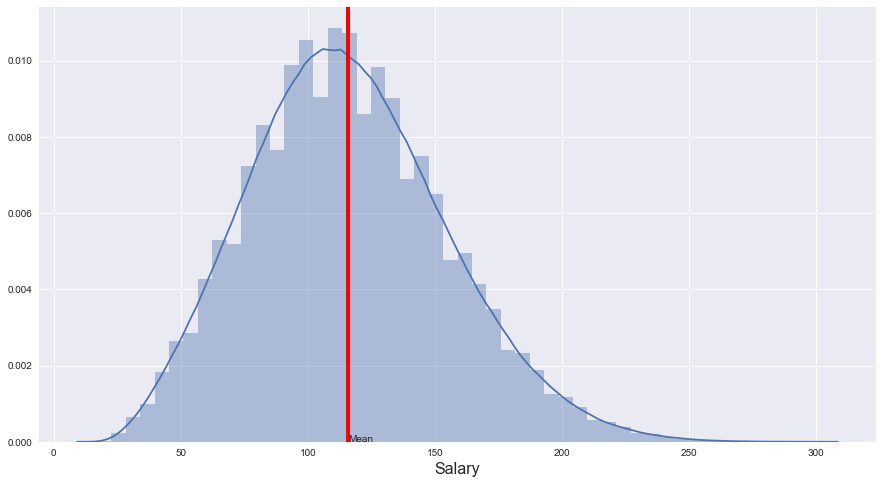

The average overall salary is 116.0
The salary standard deviation is 39.0


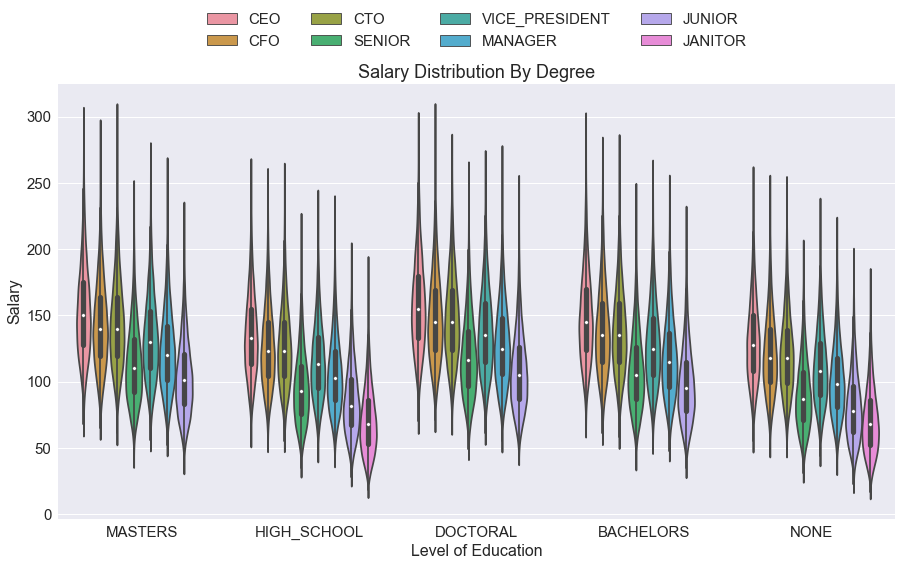

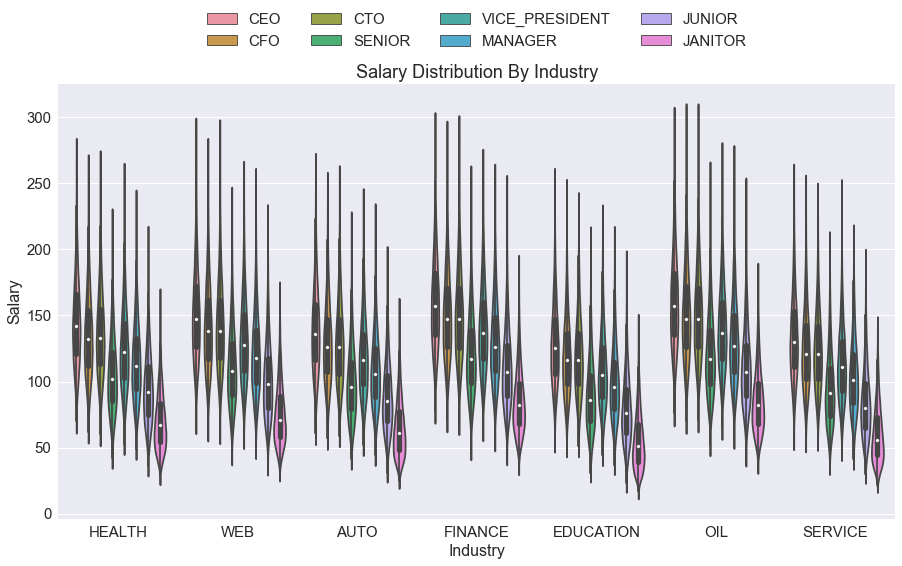

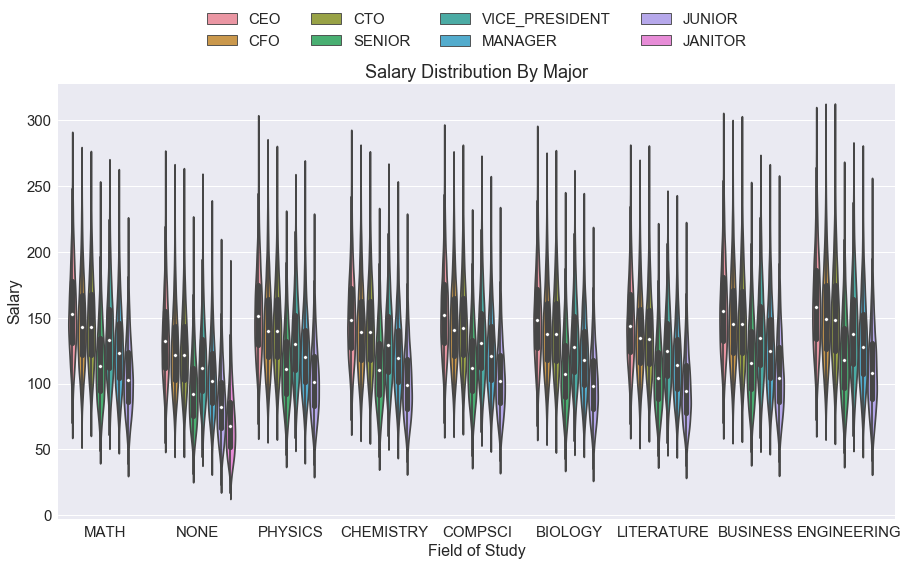



Baseline Model Information
Linear Regression score is 0.2303571550086865
The mean squared errors are [-1155.33451395 -1157.56248122 -1160.35293862 -1155.52304359
 -1147.29532369]
The average mean squared error is 1155.2136602141552




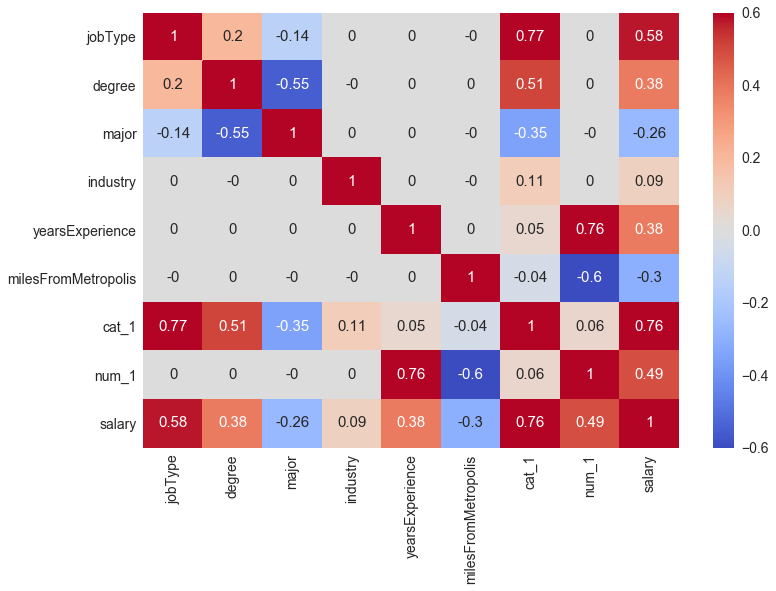

Cross Validation MSE scores for <class 'sklearn.linear_model.base.LinearRegression'> are 
 [-342.37520448 -343.56645718 -341.02783224 -341.24890813 -343.22082594]

Avg MSE for <class 'sklearn.linear_model.base.LinearRegression'> 
 is 342.28784559637705



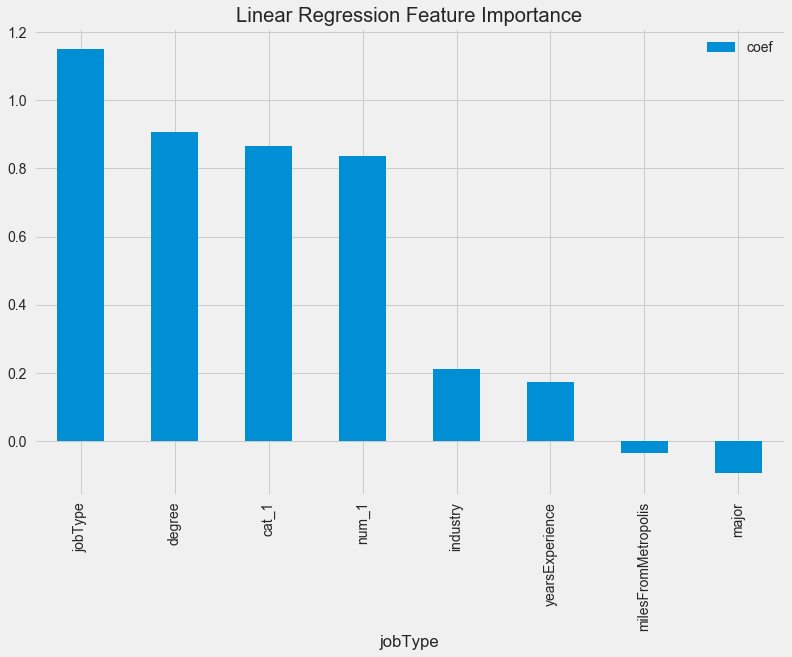

Cross Validation MSE scores for <class 'sklearn.linear_model.ridge.RidgeCV'> are 
 [-342.37519582 -343.56648888 -341.02784395 -341.24886333 -343.22083443]

Avg MSE for <class 'sklearn.linear_model.ridge.RidgeCV'> 
 is 342.2878452822695



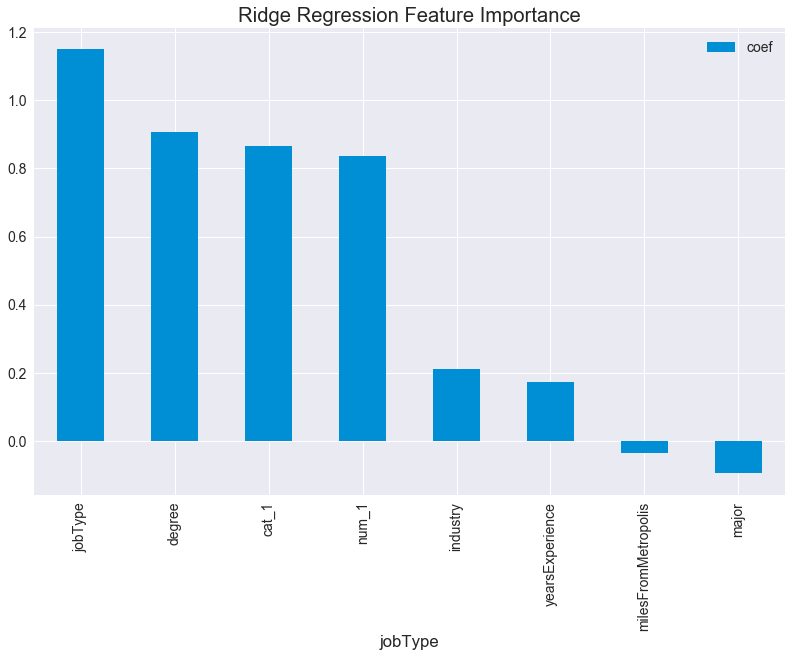

Cross Validation MSE scores for <class 'sklearn.ensemble.forest.RandomForestRegressor'> are 
 [-341.88431825 -343.40749208 -340.6557282  -340.87556745 -342.58355955]

Avg MSE for <class 'sklearn.ensemble.forest.RandomForestRegressor'> 
 is 341.88133310381414



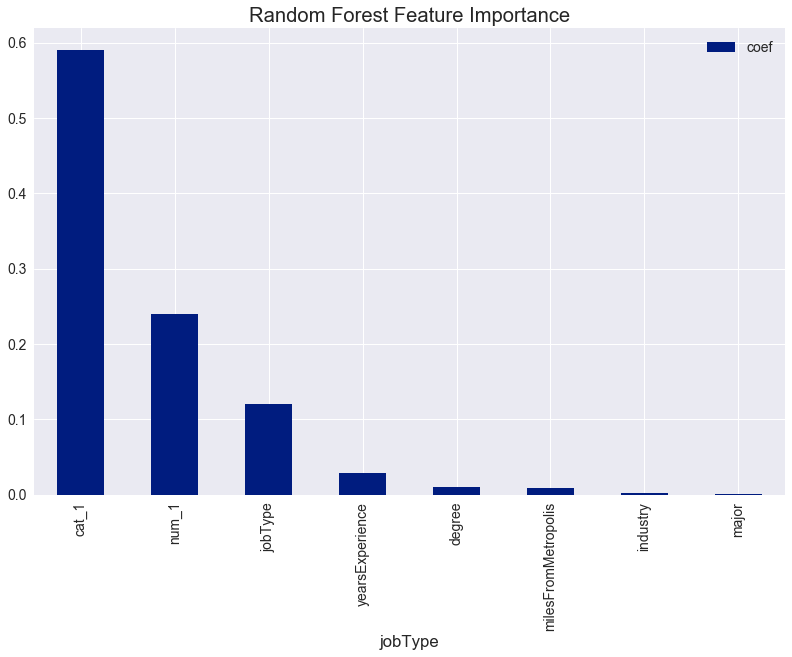

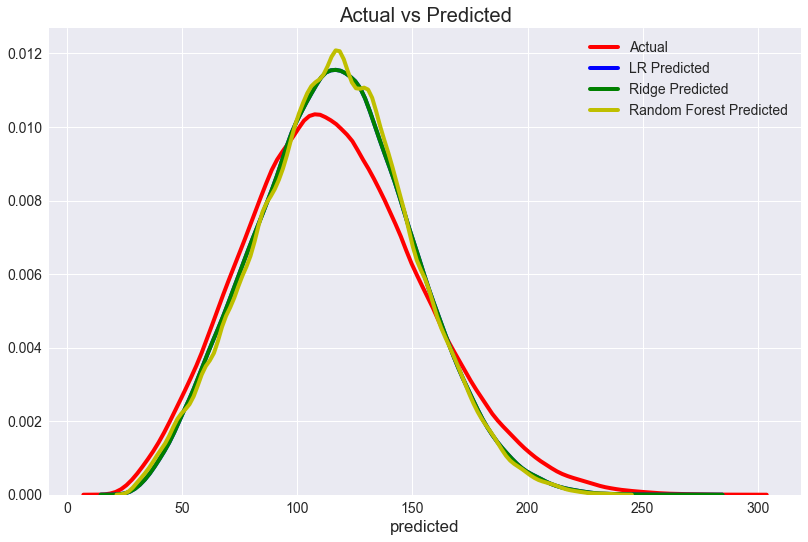

min value in models = 341.88133310381414, estimator = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=60,
                      max_features=5, max_leaf_nodes=None,
                      min_impurity_decrease=0.01716494628293873,
                      min_impurity_split=None, min_samples_leaf=92,
                      min_samples_split=13, min_weight_fraction_leaf=0.0,
                      n_estimators=41, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
Model written to disk!
Loaded model from disk!
Running model on test data ....
Model finished -- the first 10 predicted values are [113.84394473 111.29775289 142.55924065 130.77878183 142.80459494
 127.75837049 151.52488306  90.48819048  78.65916343 126.96560786]


In [9]:
## load the data
ld = LoadData("train_features.csv", "test_features.csv", "train_salaries.csv")
(raw_train_feat, raw_test_feat, raw_train_sal) = ld.load()

## investigate the data
inv = InvestigateData(raw_train_feat, raw_test_feat, raw_train_sal)
inv.get_data_info(train_features = raw_train_feat, 
                  test_features = raw_test_feat, 
                  train_salaries = raw_train_sal)
feat_sal_df, basecase_df = inv.data_investigate()

## do some EDA
job_type = ['CEO', 'CFO', 'CTO', 'SENIOR', 'VICE_PRESIDENT', 'MANAGER', 'JUNIOR', 'JANITOR']
eda = EDA(feat_sal_df, 'jobType', 'salary', 'degree', 'industry', 'major', job_type)
eda.plot_sal()
eda.plot_violin()

## run the base case
base = Baseline(basecase_df, LinearRegression(), 'yearsExperience', 
                'milesFromMetropolis', 'salary')
base.baseline_model()

## do some feature engineering
## conversion of jobType and degree to a number
jobType_encod = {'CEO':7,'CFO':6, 'CTO':5, 'VICE_PRESIDENT':4, 'MANAGER':3, 
                 'SENIOR':2, 'JUNIOR':1, 'JANITOR':0, 'NONE':0}
degree_encod = {'DOCTORAL':4, 'MASTERS':3, 'BACHELORS':2, 'HIGH_SCHOOL':1, 'NONE':0}
eng = FeatEng(feat_sal_df, jobType_encod, degree_encod, LabelEncoder())
eng.feat_engineering()
eng.check_corr()
  
## set up the estimators
reg_estimators = {'lr': LinearRegression(),
                  'ridge': RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]),
                  'rfr': RandomForestRegressor(n_estimators=41,
                           max_depth=60,          
                           min_samples_split=13,
                           min_samples_leaf=92,
                           max_features=5,
                           max_leaf_nodes=None,
                           min_impurity_decrease=0.01716494628293873
                           )
                 }

## run the comparison
compest = CompareEst(reg_estimators)
compest.setup_data_split()
key = compest.compare_estimators()

## save and load the best model
file_name = compest.save_est(key)
loaded_model = compest.load_est(file_name)

## run out of sample data through the model
oos = OutOfSample(raw_test_feat, loaded_model, jobType_encod, degree_encod, LabelEncoder())
oos.basic_feat()
oos.run_model()
##'''

<div class="alert alert-block alert-info">
<p><b>Summary of the salient observations</b></p>

<p>First we take a look at all of our data files.  We notice the number of rows, the field types and can check for any glaring problems with the data that will need to be fixed</p>

</p> We observe that there are a lot of 'NONE' values in the degree and major columns.  This could potentially be a  problem that we will have to deal with.  Clarification on the validity of these entries will need to come form the projects sponsors or business analysts.</p>

<p>From the graph we can see that salaries fairly normally distributed with a mean of $116,000 and a fat tail on the right indicating higher salaries at the top end.</p>

<p>The violin plots give us quite a bit of information from the range to the distribution and we can also observe trends in the data.</p> 

<p>The results from our basecase are not very good and only furnish us with a baseline MSE which undoubtedly will improve with more feature engineering and additional imporvements that will be made with the selected estimators.</p>

<p> Hyporthesizing about our regression problem and which estimators might be appicable in this situation it was decided to try the following esitmators.</p>
<p>1. Linear Regression - with multiple features</p>
<p>2. Ridge Regression</p>
<p>3. Random Forest Regressor</p>

<p> Interesting to see how different estimators place more importance on various features.  One point of improvment is to add more features and observe this on a larger scale.</p>

<p>Linear regression and Ridge regression produced the same predicted salary values. Random Forest had more variablity in its predicted salary values</p>

<p>There really wasn't a clear cut winner because all the chosen estimators produced an MSE very close to 340.  Given that we need to make a choice, Random Forest Regression estimator was  chosen as the winner with the caveat mentioned above.  As we add features the performance of these three estimators could diverge significantly and additional modifications will need to be made.</p>

<p></p>
</div>